Ejercicio 1

In [218]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

In [219]:
### a

# obtain the headers
with open('wine.csv', 'r') as file:
    headers = file.readline().split(',')

# read the data from the csv file
data = np.genfromtxt('wine.csv', delimiter=',')

# drop the text headers and keep only the values
data = data[1:]

In [220]:
### b

# get the independant variables
x = data[:, :-1]

# get the single dependant variable
y = data[:, -1]

1.995906561123877e-17
0.9971870549059036


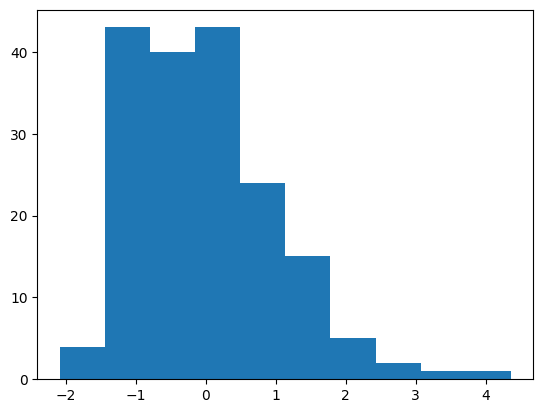

In [221]:
### c

# normalize the data for each column
for col in range(x.shape[1]):

    # calculate the mean
    column_mean = np.mean(x[:, col])
    
    # calculate the standard deviation
    squared_diff = 0
    for row in range(x.shape[0]):
        squared_diff = squared_diff + (x[row, col] - column_mean) ** 2
    column_std = np.sqrt(squared_diff / (x.shape[0] - 1))
    
    # normalize the column
    x[:, col] = (x[:, col] - column_mean) / column_std

# print the mean and std of a random column and see if it is normalized
print(np.mean(x[:, 4]))
print(np.std(x[:, 4]))
plt.hist(x[:,4])
plt.show()

¿Por que es importante este paso?

Este paso de estandarizar la data es importante asi todas las columnas estan en la misma escala y esto hace que luego cuando tengamos que calcular distancias entre vinos (puntos en el espacio) no se vea afectada la cuenta debido a diferencias de escalas entre propiedades (columnas), de otra forma podria pasar que una dimension (propiedad) sea mucho mas influyente que las otras debido a cuestiones solamente numericas.

In [222]:
### d

# calculate the covariance matrix

rows_qty = x.shape[0]
col_qty = x.shape[1]

cov = np.zeros(shape=(col_qty, col_qty))

for i in range(col_qty):
    for j in range(col_qty):
        i_col_mean = np.mean(x[:, i])
        j_col_mean = np.mean(x[:, j])
        
        for k in range(rows_qty):
            cov[i, j] = cov[i, j] + (x[k, i] - i_col_mean) * (x[k, j] - j_col_mean)
        cov[i, j] = cov[i, j] / rows_qty

¿Que representa la matriz de covarianza? ¿Que dimensionestiene y que propiedades cumple?

La matriz de covarianza nos dice la relación entre dos o más variables aleatorias, Cada una de sus entradas contiene la covarianza entre cada par de variables y sobre cómo estas variables varían juntas.

La matriz es cuadrada y tiene dimensiones de n x n donde n es el numero de variables aleatorias, en este caso seria 13 x 13 que es la cantidad de variables independientes.

La matriz de covarianza siempre es simetrica y semidefinida positiva lo cual lo hace importante ya que la hace semejante a una matriz diagonal donde las entrada son sus autovalores y estos son reales.

In [223]:
### e

# obtain the eigenvalue using the Rayleigh quotient
def get_related_eigenvalue(matrix, eigenvector):
    transposed_eigenvector = np.transpose(eigenvector)
    return transposed_eigenvector @ matrix @ eigenvector / (transposed_eigenvector @ eigenvector)

def get_max_eigenvector_and_eigenvalue(matrix):

    # start with a random vector
    eigenvector = np.random.rand(matrix.shape[1])
    previous_eigenvalue = 0

    # apply the power method multiplying the matrix with the vector and dividing by the norm and stop when its converges
    for _ in range(20):
        
        eigenvector = (matrix @ eigenvector) / np.linalg.norm(matrix @ eigenvector)
        eigenvalue = get_related_eigenvalue(matrix, eigenvector)

        # stop when the eigenvalue converges
        if (eigenvalue - previous_eigenvalue) < 0.00001:
            break

        previous_eigenvalue = eigenvalue

    return eigenvector, eigenvalue


max_cov_eigenvector, max_cov_eigenvalue = get_max_eigenvector_and_eigenvalue(cov)

# print the results
print(max_cov_eigenvalue)
print(max_cov_eigenvector)

4.679411571426614
[ 0.14470401 -0.24501294 -0.00180488 -0.23932747  0.14222456  0.39471142
  0.42293183 -0.2985104   0.31346013 -0.08820597  0.29649811  0.37604004
  0.28703486]


In [224]:
### f

def get_max_eigenvectors_and_eigenvalues(matrix, quantity):
    matrix_copy = matrix.copy()
    eigenvectors = np.zeros(shape=(quantity, matrix.shape[1]))
    eigenvalues = np.zeros(quantity)

    # get the maximum eigenvector and eigenvalue and remove it from the matrix
    for i in range(quantity):
        eigenvector, eigenvalue = get_max_eigenvector_and_eigenvalue(matrix_copy)
        eigenvectors[i] = eigenvector
        eigenvalues[i] = eigenvalue
        matrix_copy = matrix_copy - eigenvalue * np.outer(eigenvector, eigenvector)

    return eigenvectors, eigenvalues

eigenvectors, eigenvalues = get_max_eigenvectors_and_eigenvalues(cov, cov.shape[0])

¿Como se relaciona la cantidad de autovalores con la cantidad de propiedades de los vinos?
¿Que representan cada unos de los autovectores correspondientes?

La cantidad de autovalores es la misma que la cantidad de propiedades ya que la matriz de covarianza tiene dimension n x n propiedades y por lo tanto n autovalores.

Cada uno de los autovectores asociado con un autovalor de la matriz de covarianza representa la direccion del espacio n dimensional por la cual obtenemos la mayor varianza y por lo tanto la mayor informacion posible.

El autovector relacionado con el primer autovalor sera la direccion con mayor varianza.

El segundo va a ser la segunda direccion con mas varianza y ademas ortogonal a la primera

El tercero sera la tercera direccion con mas varianza y ortogonal a los otros 2 y asi sucesivamente.

In [225]:
### g

# knn model for predicting the result label
class knn_model:
    def __init__(self, x, y, neighbors):
        self.x = x
        self.y = y
        self.neighbors = neighbors

    def predict(self, input):
        distances = np.zeros(len(self.x))
        results = np.zeros(len(input))

        # calculate the distance between the input and the known data points and return the label of the nearest point
        for i in range(len(input)):
            for j in range(len(self.x)):
                distances[j] = np.linalg.norm(input[i] - self.x[j])
            
            # get the indexes of most similar points
            min_distance_indexes = np.argsort(distances)[:self.neighbors]

            # predict the label of the input using the most similar points
            unique_values, counts = np.unique(y[min_distance_indexes], return_counts=True)
            most_frequent_label = unique_values[np.argmax(counts)]

            results[i] = most_frequent_label
        
        return results

# predict the result label of the input array containing the samples atributes and needs the eigenvectors of the covariance matrix
def predict_data(x, y, input, eigenvectors):

    # transform the data into the new basis using the eigenvectors
    transformed_x = x @ np.transpose(eigenvectors)
    
    # create a knn model using the transformed data and the labels
    model = knn_model(transformed_x, y, neighbors=5)

    # predit the result transforming the input data into the new basis and then using the knn model
    return model.predict(input @ np.transpose(eigenvectors))

# take random samples for testing the model
test = x[::10]
correct_labels = y[::10]
predicted_data = predict_data(x, y, test, eigenvectors)

for i in range(len(predicted_data)):
    print("correct value is: " + str(correct_labels[i]) + "    prediction is: " + str(predicted_data[i]))

print("Accuracy: " + str(100 * np.sum(predicted_data == correct_labels) / len(correct_labels)) + "%")

correct value is: 1.0    prediction is: 1.0
correct value is: 1.0    prediction is: 1.0
correct value is: 1.0    prediction is: 1.0
correct value is: 1.0    prediction is: 1.0
correct value is: 1.0    prediction is: 1.0
correct value is: 1.0    prediction is: 1.0
correct value is: 2.0    prediction is: 2.0
correct value is: 2.0    prediction is: 2.0
correct value is: 2.0    prediction is: 2.0
correct value is: 2.0    prediction is: 2.0
correct value is: 2.0    prediction is: 2.0
correct value is: 2.0    prediction is: 2.0
correct value is: 2.0    prediction is: 2.0
correct value is: 3.0    prediction is: 3.0
correct value is: 3.0    prediction is: 3.0
correct value is: 3.0    prediction is: 3.0
correct value is: 3.0    prediction is: 3.0
correct value is: 3.0    prediction is: 3.0
Accuracy: 100.0%


Ejercicio 2

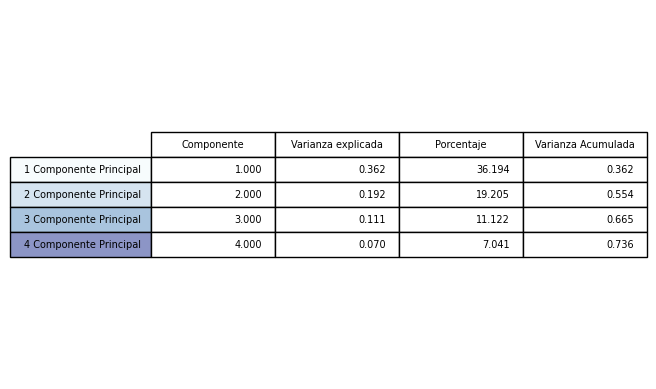

In [226]:
### a

iter = 4
components = []
explain_varianze = []
percent_explain_varianze = []
accumulated_explain_varianze = []

# obtain the data for the table
for i in range(iter):
    components.append(i + 1)
    explain_varianze.append(eigenvalues[i] / np.sum(eigenvalues))
    percent_explain_varianze.append(100 * explain_varianze[i])
    accumulated_explain_varianze.append(np.sum(eigenvalues[0:i + 1]) / np.sum(eigenvalues))

data =  np.transpose(np.array([
            components,
            explain_varianze,
            percent_explain_varianze,
            accumulated_explain_varianze,
        ]))

# plot the table
cell_text = []
for row in data:
    cell_text.append([f'{x:1.3f}' for x in row])

columns = ('Componente', 'Varianza explicada', 'Porcentaje', 'Varianza Acumulada')
rows = ['%d Componente Principal' % x for x in (1,2,3,4)]
colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))

the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='center')

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
the_table.scale(1, 1.5)

plt.show()

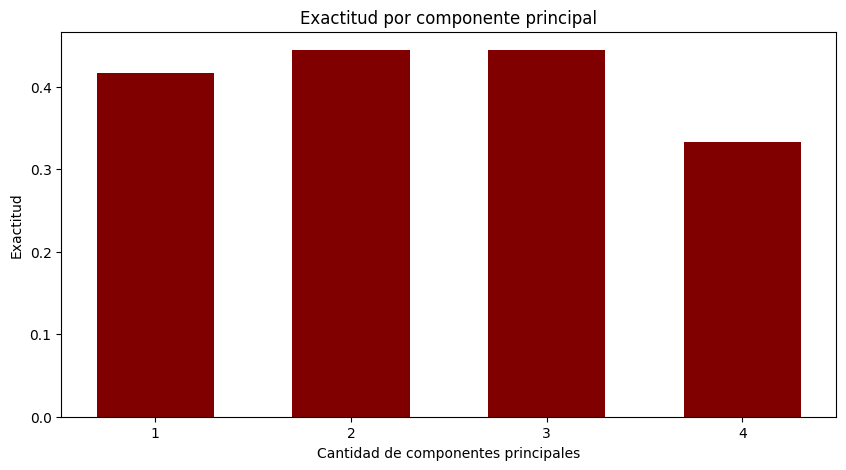

In [227]:
### b

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# def confusion_matrix(y_test, y_pred, labels):
#     confusion_matrix = np.zeros((len(labels), len(labels)))

#     for i in range(len(labels)):
#         for j in range(len(labels)):
#             confusion_matrix[i, j] = np.sum((y_test == labels[i]) & (y_pred == labels[j]))

#     return confusion_matrix


# return the accuracy and the confusion matrix for the given numbers of eigenvectors
def benchmark(x, y, eigenvectors):

    # make a shuffled training and test set
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
    
    # create a knn model using the transformed data and the labels
    knn = knn_model(x_train @ np.transpose(eigenvectors), y_train, neighbors=5)

    # predit the result transforming the test data into the new basis and then using the knn model
    y_pred = knn.predict(x_test @ np.transpose(eigenvectors))

    # calculate the accuracy
    accuracy = np.sum(y_pred == y_test) / len(y_test)

    # return accuracy, confusion_matrix(y_test, y_pred, np.unique(y))
    return accuracy, confusion_matrix(y_test, y_pred, labels=np.unique(y))

iter = 4
x_labels = []
y_lables = []
confusion_matrixes = []

for i in range(iter):
    accurracy, conf_matrix = benchmark(x, y, eigenvectors[np.arange(0, i + 1), :])
    x_labels.append(f'{i + 1}')
    y_lables.append(accurracy)
    confusion_matrixes.append(conf_matrix)

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(x_labels, y_lables, color ='maroon', width = 0.6)
 
plt.xlabel("Cantidad de componentes principales")
plt.ylabel("Exactitud")
plt.title("Exactitud por componente principal")
plt.show()


In [194]:
print (confusion_matrixes[0])

[[10  4  0]
 [ 8  5  0]
 [ 6  3  0]]


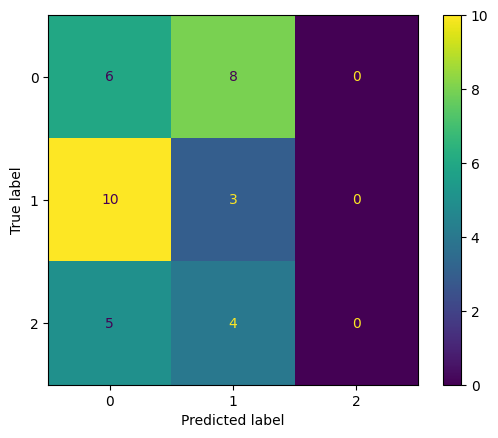

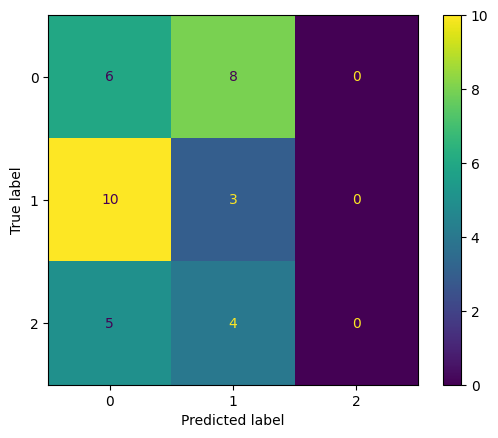

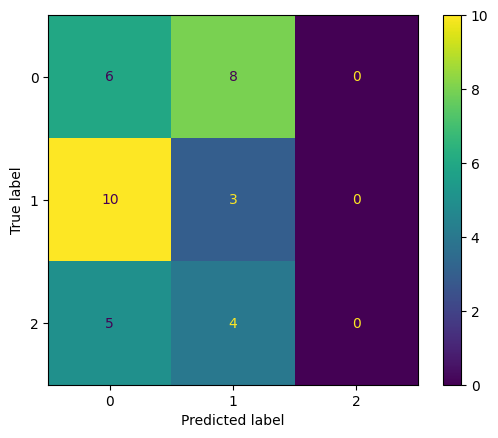

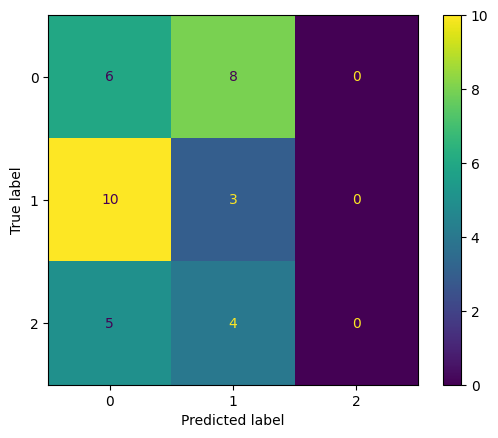

In [209]:
### c

from sklearn.metrics import ConfusionMatrixDisplay

for i in range(iter):
    disp = ConfusionMatrixDisplay(confusion_matrixes[i])
    disp.plot()
    plt.show()